In [1]:
import os
os.chdir("../..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [2]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

from commons.api.segment_saliency import generate_segmentation_mask, pixels_to_polygon, polygon_to_pixels, generate_saliency_from_polygon, plot_polygon
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images
from commons.api.vit import load_vit
from commons.api.viz import visualize_saliency_overlay
from commons.api.method.attention_rollout import rollout, grad_rollout, vit_saliency_map
from commons.api.metric.ior import insalient_outsalient_ratio

In [3]:
os.chdir("abid/ior_analysis")

In [4]:
vit_model = load_vit()

Using cache found in C:\Users\Khisrow/.cache\torch\hub\facebookresearch_deit_main


In [5]:
model = YOLO('yolov8m-seg.pt')

def generate_yolo_segmentation_mask(model, img_input):
    results = model(img_input)
    if results[0].masks != None:
        return np.array(Image.fromarray(results[0].masks.cpu().data[0].numpy()).resize((224, 224)))
    else:
        return results[0].masks

In [6]:
import json
def get_imagenet_classes(): 
    classes_json = "../../data/imagenet_class_index.json"
    classes = json.load(open(classes_json))
    classes = np.array(list(classes.values()))
    return classes[:, 1]

In [7]:
classes = get_imagenet_classes()

In [9]:
ground_saliencies = np.load('../data/ground_saliency_images/ground_saliencies_2_fixed.npy')
images = np.load('../data/ground_saliency_images/images_2_fixed.npy')
obj_masks = np.load('../data/ground_saliency_images/obj_masks_2_fixed.npy')

In [10]:
def insalient_outsalient_ratio_new(reference, comparative, object_mask):
    assert(reference.shape == comparative.shape)
    agreement = reference * comparative

    epsilon = 1e-8
    insalient_agreement = (agreement * object_mask) + epsilon
    # insalient_agreement_norm = insalient_agreement / insalient_agreement.max()
    # insalient_agreement_norm = np.where(insalient_agreement_norm >= 0.9, 1, insalient_agreement_norm)

    reference_distribution = reference + epsilon
    reference_distribution = reference_distribution / reference_distribution.sum()
    
    reference_in_distribution = (reference_distribution * object_mask)

    # Expect in-saliency agreement to be in the same place. Also the value that is concentrated in the reference must be the one with greatest agreement as well.
    insalient = np.sum(insalient_agreement * reference_in_distribution)

    # expect the saliency outside mask to be spurious and spread out and therefore, not coincide with each other in both saliencies
    outsalient_agreement = (reference * np.logical_not(object_mask).astype(float)) + epsilon
    # outsalient_agreement_norm = outsalient_agreement / outsalient_agreement.max()
    # outsalient_agreement_norm = np.where(outsalient_agreement_norm >= 0.9, 1, outsalient_agreement_norm)

    reference_out_distribution = reference_distribution * np.logical_not(object_mask).astype(float)

    # out-salient distribution must also not have large values
    outsalient = np.sum(outsalient_agreement * reference_out_distribution)

    return insalient/ (outsalient + insalient)


def ior_singluar(saliency, object_mask):
    epsilon = 1e-9
    inner_saliency = (saliency * object_mask) + epsilon
    outer_saliency = saliency * np.logical_not(object_mask).astype(float)
    
    return np.sum(inner_saliency) / (np.sum(inner_saliency) + np.sum(outer_saliency))

In [11]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

### Visualization of how IOR works.
1. The punishes saliencies outside
How IOR changes when:
- The focus areas moves around (DONE)
- When the focus area gets spread out
- When there is less concentration of values, meaning more disjointed. 
- As saliency bleeds outside the object (DONE)
- As focus of the saliency changes to the outside (DONE)

### Do the same analysis for perturbations

### Change IOR so that its value is agnostic of the size of the object

<hr>

### 1. Preliminary IOR Examples using Synthetic data

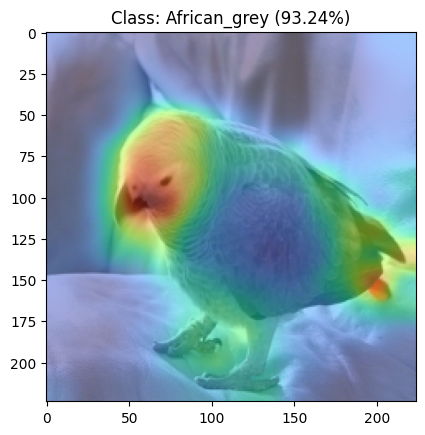

In [12]:
idx = 6

vit_probs, vit_idx, (vit_cls_mask, vit_distill_mask) = vit_saliency_map(Image.fromarray(images[idx]), vit_model)
visualize_saliency_overlay(plt.gca(), Image.fromarray(images[idx]), vit_cls_mask, vit_probs, vit_idx, classes);


0: 640x640 1 bird, 1 bed, 29.1ms
Speed: 156.8ms preprocess, 29.1ms inference, 146.0ms postprocess per image at shape (1, 3, 640, 640)


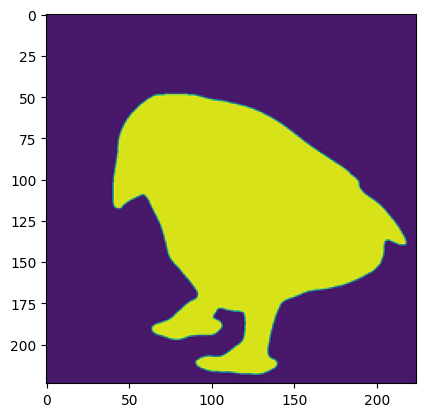

In [13]:
ref_mask = generate_yolo_segmentation_mask(model, images[idx])
plt.imshow(ref_mask)

In [14]:
from scipy.signal import convolve2d
from PIL import ImageDraw

In [15]:
def gkern(l=5, sig=1.):
    # side length `l`
    # sigma `sig`
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [63]:
def generate_focus_point(img, focus_points):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for idx, fp in enumerate(focus_points):
        p, r, fill_value = fp
        left_up_point = (p[0]-r, p[1]-r)
        right_down_point = (p[0]+r, p[1]+r)
        two_point_list = [left_up_point, right_down_point]
        draw.ellipse(two_point_list, fill=fill_value)
    img_np = np.array(img)
    kernel = gkern(30, 7)
    img_np = convolve2d(img_np, kernel, mode="same")
    return img_np

In [207]:
def plot_ior_comparison_focus_points(focus_points, changes):
    fig , axes = plt.subplots(ncols=2, nrows=1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    sal_1 = generate_focus_point(blank_img, focus_points)
    axes[0].imshow(sal_1)
    axes[0].set_title("Comparative")
    for idx, fp in enumerate(focus_points):
        xy, r, fill_value = fp
        x, y = xy
        axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
        

    changed_focus_ps = []
    for idx, change in enumerate(changes):
        translate, scale, value = change
        fp = []
        pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
        fp.append(pos)
        fp.append(focus_points[idx][1] * scale)
        fp.append(focus_points[idx][2] * value)
        changed_focus_ps.append(fp)

    sal_2 = generate_focus_point(blank_img, changed_focus_ps)
    axes[1].imshow(sal_2 * ref_mask)
    for idx, fp in enumerate(changed_focus_ps):
        xy, r, fill_value = fp
        x, y = xy
        axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    axes[1].set_title(f"Reference. IOR = {insalient_outsalient_ratio_new(sal_2, sal_1, ref_mask):.4f}");

In [209]:
del focus_points
del sal_1

In [210]:
blank_img = np.zeros((224, 224))
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 15, 0.4], # 1
                [[100, 160], 10, 0.8], # 2
                [[160, 100], 16, 0.4], # 3
                [[75, 90], 15, 0.7]]  # 4

#### When there are no saliency outside the object

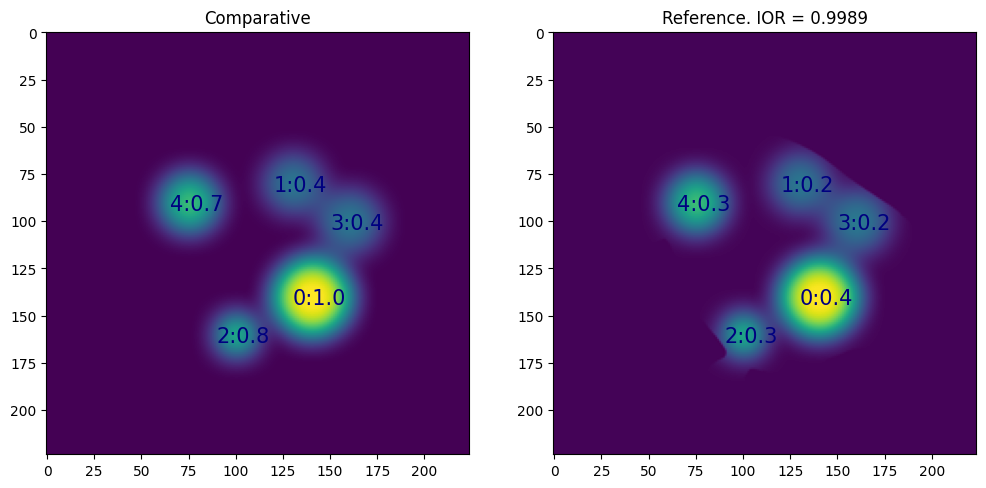

In [211]:
# The relative values within the objects does not change the metric all that much
# In here the values have been lessened yet the value barely changes
plot_ior_comparison_focus_points(focus_points, [[(0, 0), 1, 0.4], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(0, 0), 1, 0.4], # 2
                                                [(0, 0), 1, 0.4], # 3
                                                [(0, 0), 1, 0.4]]) # 4

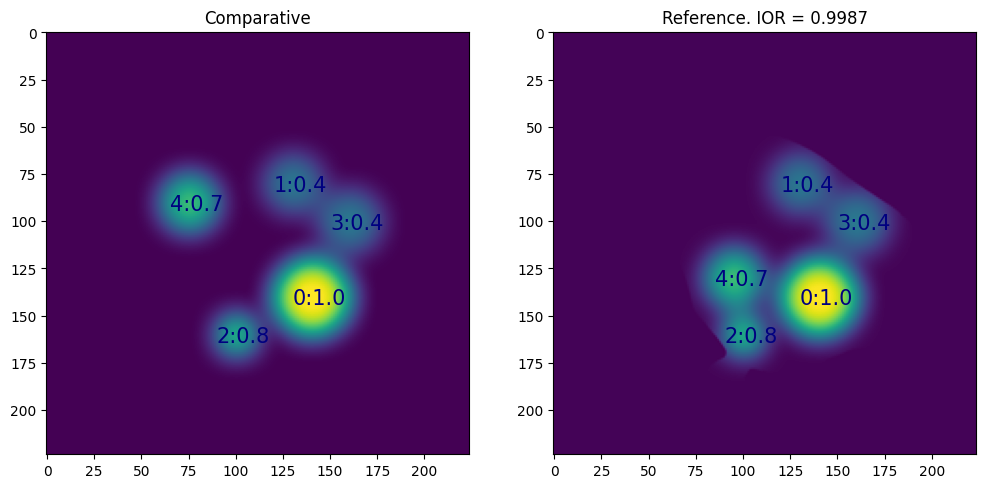

In [212]:
plot_ior_comparison_focus_points(focus_points, [[(0, 0), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(0, 0), 1, 1], # 2
                                                [(0, 0), 1, 1], # 3
                                                [(20, 40), 1, 1]]) # 4

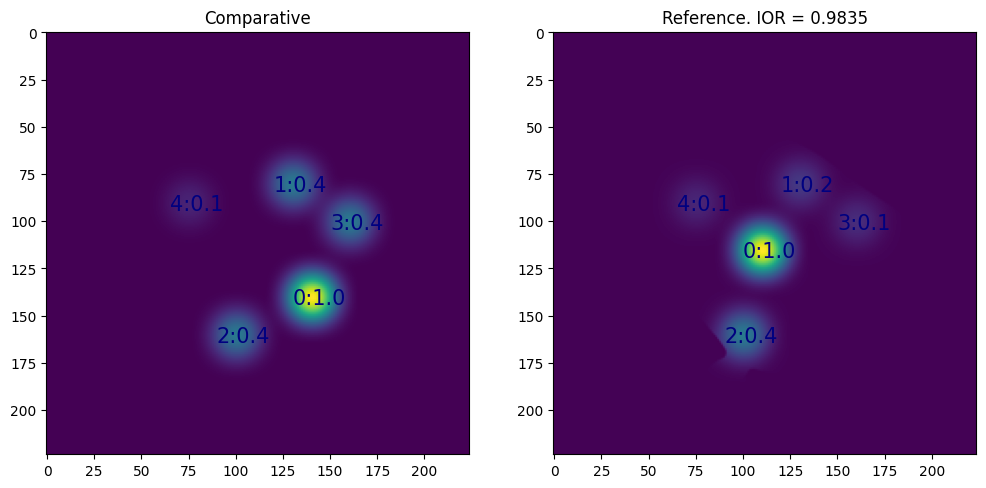

In [290]:
# However, the values that does not match the same position in both of the saliency maps (agreement) lowers the final metric value.
# Yet, since the saliency values do not bleed into outside the object, the discrepancies is not as prevalent as when we have saliency outside
# the object. Therefore, when all are inside object, the value is still high as it shows that the model did focus on the object itself.
# So, to clarify, the position of insalient values only matter when we have values outside the object.
focus_points = [[[140, 140], 10, 1.0], # 0
                [[130, 80], 10, 0.4], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.4], # 3
                [[75, 90], 10, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(-30, -25), 1, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(0, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

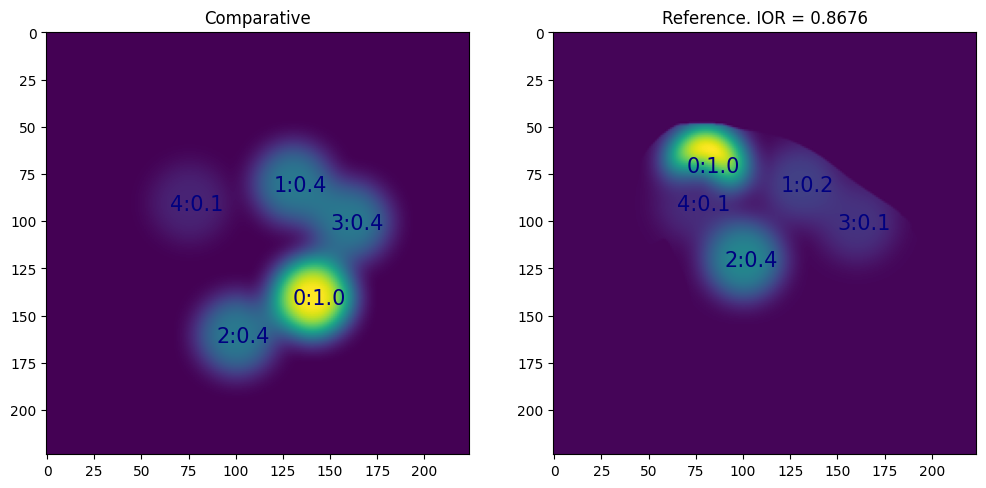

In [294]:
# Another example for the case above
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 20, 0.4], # 1
                [[100, 160], 20, 0.4], # 2
                [[160, 100], 20, 0.4], # 3
                [[75, 90], 20, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(-60, -70), 1, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(0, -40), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

#### When we have outsalient values (saliency values outside the object)

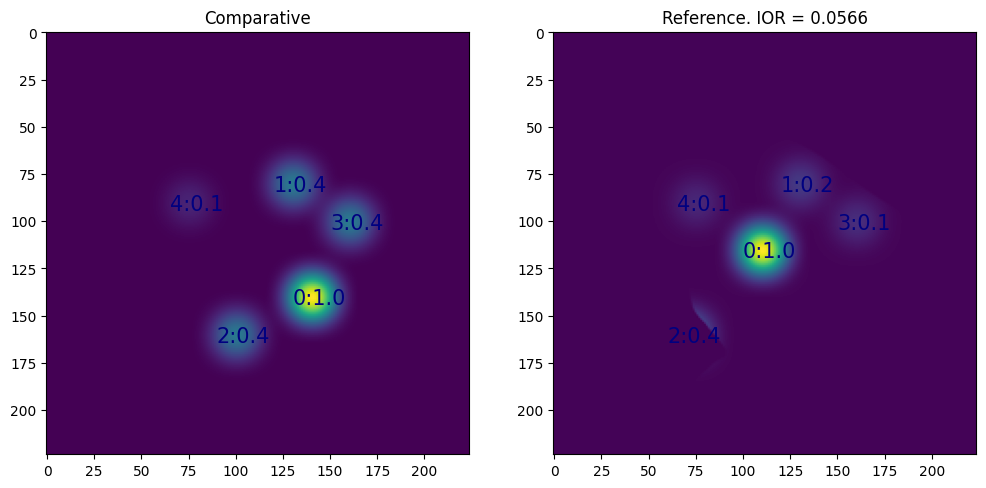

In [285]:
# To prove that the value starts decreasing the moment we go out of the object, look below (the same as above except for a saliency being
# outside the object
# As can been seen here the position of the values becomes more sensitive as we have more saliencies outside of our object

# Print a failure case here, in which if the radius is large then the value would not decrease all that much
focus_points = [[[140, 140], 10, 1.0], # 0
                [[130, 80], 10, 0.4], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.4], # 3
                [[75, 90], 10, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(-30, -25), 1, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(-30, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

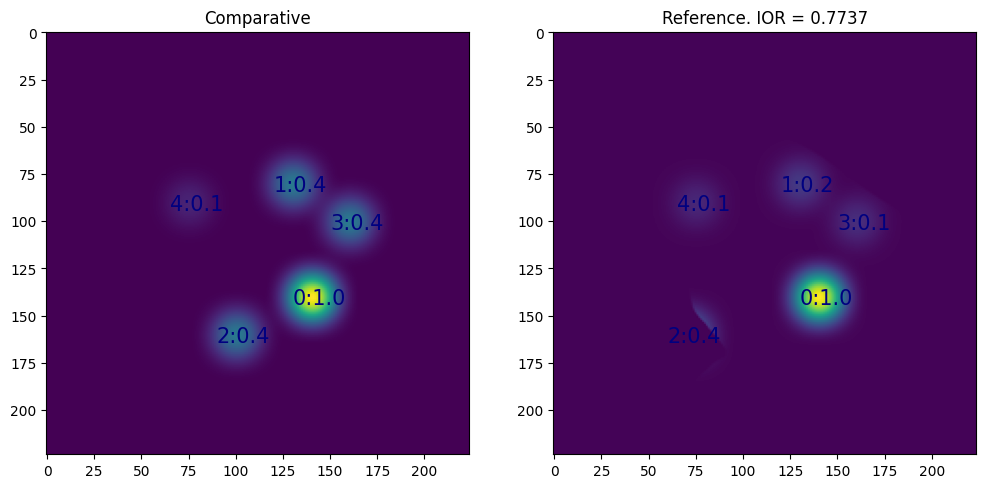

In [286]:
# In here, we have the same as above but now we have the highest saliency (idx : 0) back to its original position, which increases the value
# again, showing how sensitive the metric gets if we have saliency outside of the object

focus_points = [[[140, 140], 10, 1.0], # 0
                [[130, 80], 10, 0.4], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.4], # 3
                [[75, 90], 10, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(0, 0), 1, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(-30, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

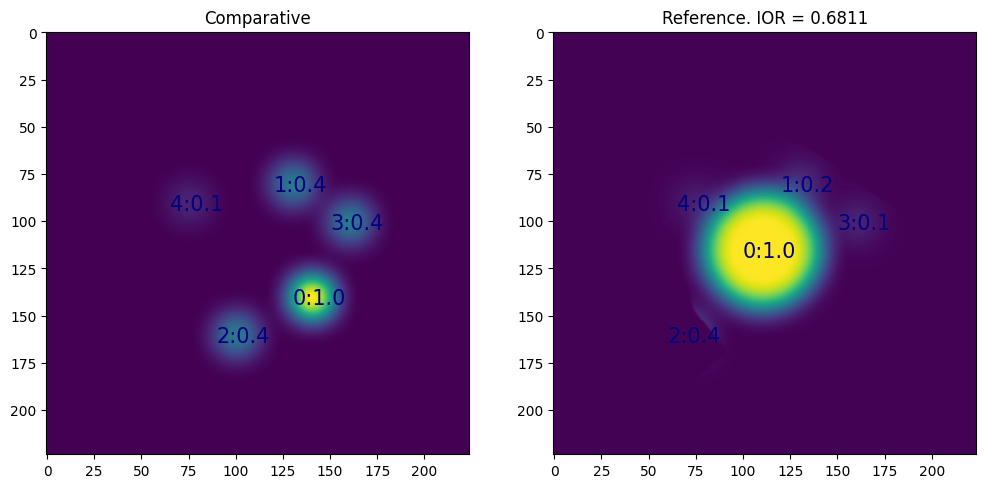

In [295]:
# Print a failure case here, in which if the radius is large then the value would not decrease all that much
# I don't know if this is a failure case, because if the model is focusing on a particular thing (small raidus) then small changes would
# mean that its focusing on a wrong thing (even if its narrow radius), however, if it is large portion, then it could be focusing on a more
# general part and so the little deviation in position there should penalize the value as much
focus_points = [[[140, 140], 10, 1.0], # 0
                [[130, 80], 10, 0.4], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.4], # 3
                [[75, 90], 10, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(-30, -25), 3, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(-30, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

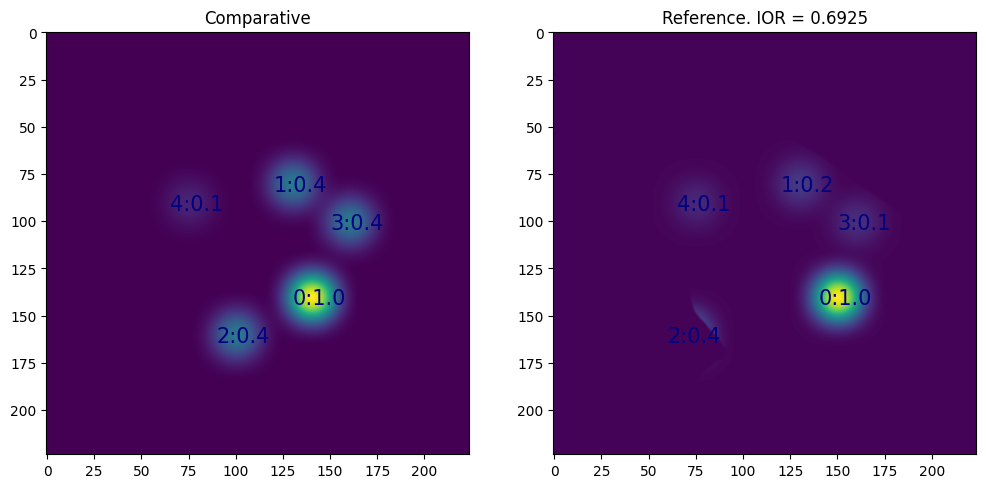

In [292]:
# As can be seen here, a slight change of the idx : 0 point (by 10 pixels) decreases our value by ~9-11 points
focus_points = [[[140, 140], 10, 1.0], # 0
                [[130, 80], 10, 0.4], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.4], # 3
                [[75, 90], 10, 0.1]]  # 4
plot_ior_comparison_focus_points(focus_points, [[(10, 0), 1, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(-30, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

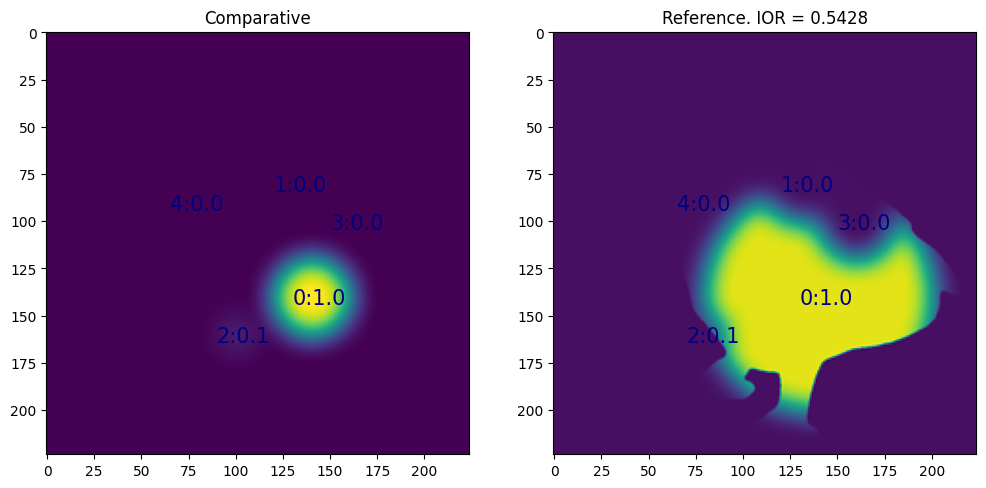

In [301]:
# When the radius of the reference increases and bleeds outside of what the saliency values allocates in the comparative saliency map,
# then the values also decreases (even though the positions might be the same here)
# This effect happens due two factors:
# 1. The values for the reference is more spread out, therefore, decrease the overall value.
# 2. Since the radius increases, the chances of going outside the object also increases which lowers the value.
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 20, 0.], # 1
                [[100, 160], 10, 0.1], # 2
                [[160, 100], 20, 0.0], # 3
                [[75, 90], 20, 0.0]]  # 4

plot_ior_comparison_focus_points(focus_points, [[(0, 0), 3, 1], # 0
                                                [(0, 0), 1, 0.4], # 1
                                                [(-20, 0), 1, 1], # 2
                                                [(0, 0), 1, 0.3], # 3
                                                [(0, 0), 1, 1]]) # 4

#### When there is less concentration of values, meaning more disjointed saliencies within the object.

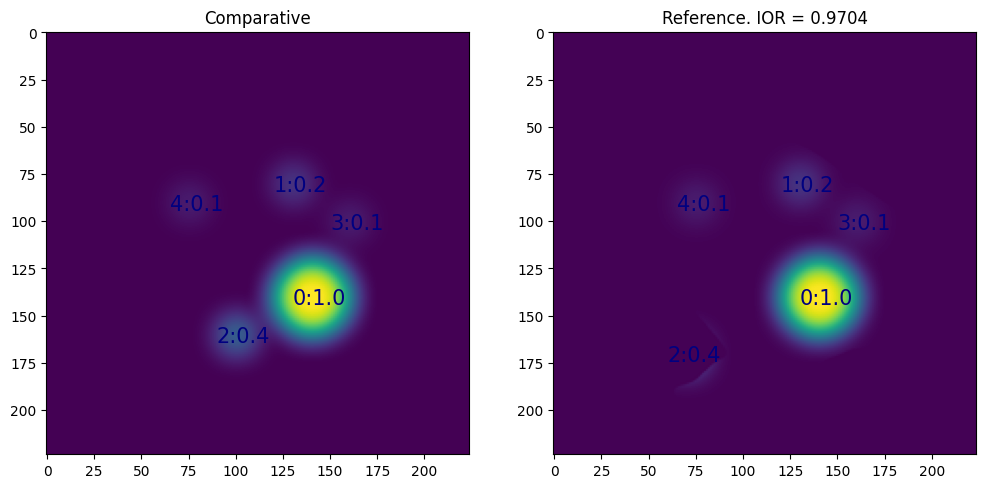

In [370]:
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 10, 0.2], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.1], # 3
                [[75, 90], 10, 0.1]]  # 4

fig , axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(12)
fig.set_figwidth(12)
sal_1 = generate_focus_point(blank_img, focus_points)
axes[0].imshow(sal_1)
axes[0].set_title("Comparative")
for idx, fp in enumerate(focus_points):
    xy, r, fill_value = fp
    x, y = xy
    axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    
changes = [[(0, 0), 1, 1], # 0
           [(0, 0), 1, 1], # 1
           [(-30, 10), 1, 1], # 2
           [(0, 0), 1, 1], # 3
           [(0, 0), 1, 1]] # 4
    
changed_focus_ps = []
for idx, change in enumerate(changes):
    translate, scale, value = change
    fp = []
    pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
    fp.append(pos)
    fp.append(focus_points[idx][1] * scale)
    fp.append(focus_points[idx][2] * value)
    changed_focus_ps.append(fp)
    
# generate_focus_point
img = Image.fromarray(blank_img)
draw = ImageDraw.Draw(img)
for idx, fp in enumerate(changed_focus_ps):
    p, r, fill_value = fp
    left_up_point = (p[0]-r, p[1]-r)
    right_down_point = (p[0]+r, p[1]+r)
    two_point_list = [left_up_point, right_down_point]
    draw.ellipse(two_point_list, fill=fill_value)
sal_2 = np.array(img)

kernel = gkern(30, 7)
sal_2 = convolve2d(sal_2, kernel, mode="same")

# randomly zero out areas inside the saliency
# pos = focus_points[0][0]
# start_pos = pos[0]-focus_points[0][1]
# end_pos = pos[0]+focus_points[0][1]
# sample_size = 10
# zero_area_size = 10
# pos_x_to_zero = random.sample(range(start_pos, end_pos+1), sample_size)
# pos_y_to_zero = random.sample(range(start_pos, end_pos+1), sample_size)
# for pos_idx in range(len(pos_x_to_zero)):
#     sal_2[pos_x_to_zero[pos_idx]:pos_x_to_zero[pos_idx]+zero_area_size, pos_y_to_zero[pos_idx]:pos_y_to_zero[pos_idx]+zero_area_size] = 0
# kernel = gkern(40, 2)
# sal_2 = convolve2d(sal_2, kernel, mode="same")

axes[1].imshow(sal_2 * ref_mask)
for idx, fp in enumerate(changed_focus_ps):
    xy, r, fill_value = fp
    x, y = xy
    axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
axes[1].set_title(f"Reference. IOR = {insalient_outsalient_ratio_new(sal_2, sal_1, ref_mask):.4f}");

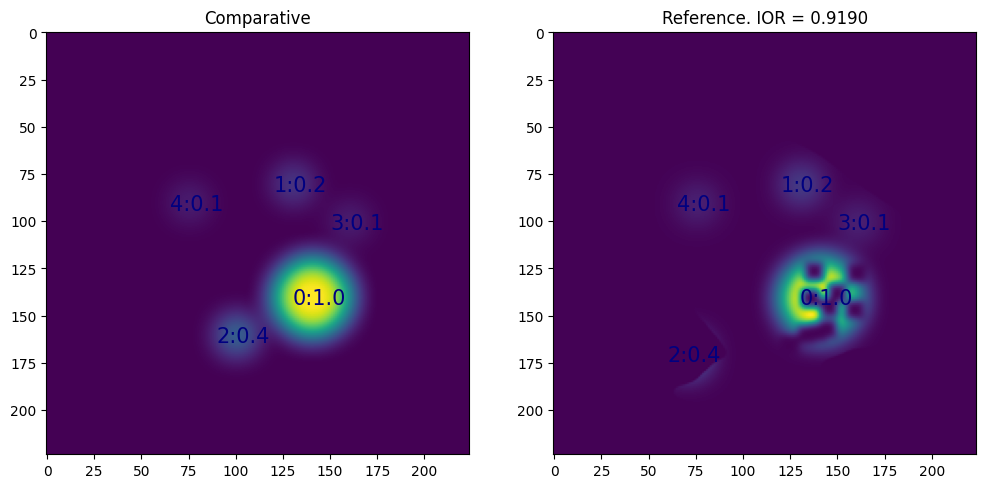

In [369]:
import random
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 10, 0.2], # 1
                [[100, 160], 10, 0.4], # 2
                [[160, 100], 10, 0.1], # 3
                [[75, 90], 10, 0.1]]  # 4

fig , axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(12)
fig.set_figwidth(12)
sal_1 = generate_focus_point(blank_img, focus_points)
axes[0].imshow(sal_1)
axes[0].set_title("Comparative")
for idx, fp in enumerate(focus_points):
    xy, r, fill_value = fp
    x, y = xy
    axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    
changes = [[(0, 0), 1, 1], # 0
           [(0, 0), 1, 1], # 1
           [(-30, 10), 1, 1], # 2
           [(0, 0), 1, 1], # 3
           [(0, 0), 1, 1]] # 4
    
changed_focus_ps = []
for idx, change in enumerate(changes):
    translate, scale, value = change
    fp = []
    pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
    fp.append(pos)
    fp.append(focus_points[idx][1] * scale)
    fp.append(focus_points[idx][2] * value)
    changed_focus_ps.append(fp)
    
# generate_focus_point
img = Image.fromarray(blank_img)
draw = ImageDraw.Draw(img)
for idx, fp in enumerate(changed_focus_ps):
    p, r, fill_value = fp
    left_up_point = (p[0]-r, p[1]-r)
    right_down_point = (p[0]+r, p[1]+r)
    two_point_list = [left_up_point, right_down_point]
    draw.ellipse(two_point_list, fill=fill_value)
sal_2 = np.array(img)

kernel = gkern(30, 7)
sal_2 = convolve2d(sal_2, kernel, mode="same")

# randomly zero out areas inside the saliency
pos = focus_points[0][0]
start_pos = pos[0]-focus_points[0][1]
end_pos = pos[0]+focus_points[0][1]
sample_size = 10
zero_area_size = 10
pos_x_to_zero = random.sample(range(start_pos, end_pos+1), sample_size)
pos_y_to_zero = random.sample(range(start_pos, end_pos+1), sample_size)
for pos_idx in range(len(pos_x_to_zero)):
    sal_2[pos_x_to_zero[pos_idx]:pos_x_to_zero[pos_idx]+zero_area_size, pos_y_to_zero[pos_idx]:pos_y_to_zero[pos_idx]+zero_area_size] = 0
kernel = gkern(40, 2)
sal_2 = convolve2d(sal_2, kernel, mode="same")

axes[1].imshow(sal_2 * ref_mask)
for idx, fp in enumerate(changed_focus_ps):
    xy, r, fill_value = fp
    x, y = xy
    axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
axes[1].set_title(f"Reference. IOR = {insalient_outsalient_ratio_new(sal_2, sal_1, ref_mask):.4f}");

<hr>